# Description:
In this notebook we 

# TODO:
- Use title instead of full content to build model
- apply clustering,
- use tf embedding projector or dash app to visualize embeddings
- perform similarity queries based on input words/ sentences

In [1]:
from utility import CorpusPreprocess, check_random_doc_similarity, compare_documents, export_test_results
import os
import collections
import numpy as np
from nltk.corpus import stopwords
from string import punctuation
from gensim import models, corpora, matutils
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [27]:
data_path = os.path.join("..", "data", "raw", "bbc")
models_path = os.path.join("..", "models")

# Reading files into memory
all_files = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(data_path)) for f in fn][1:]
corpus = []
for file in all_files:
    with open(file, 'r') as f:
        corpus.append(f.read())

# Saving topics from each article
topics = [path.split("\\")[-2] for path in all_files]

In [28]:
# Train/ test split
train_corpus, test_corpus, train_topics, test_topics = train_test_split(corpus, topics, test_size=0.1, random_state=0)

# Preprocessing
prep = CorpusPreprocess(stop_words=stopwords.words('english'), lowercase=True, strip_accents=True,
                        strip_punctuation=punctuation, stemmer=True, max_df=0.5, min_df=3)
processed_train_corpus = prep.fit_transform(train_corpus)
processed_test_corpus = prep.transform(test_corpus)

In [9]:
# # BOW
# dictionary = corpora.Dictionary(processed_train_corpus)
# num_terms = len(dictionary.token2id)
# num_train_docs = len(processed_train_corpus)
# num_test_docs = len(processed_test_corpus)
# vect_train_corpus = matutils.corpus2dense([dictionary.doc2bow(text) for text in processed_train_corpus],
#                                           num_terms, num_train_docs)
# vect_test_corpus = matutils.corpus2dense([dictionary.doc2bow(text) for text in processed_test_corpus],
#                                           num_terms, num_test_docs)

# # Train doc2vec model
# TaggedDocument format (input to doc2vec)
tagged_corpus = [models.doc2vec.TaggedDocument(text, [i]) for i, text in enumerate(processed_train_corpus)]
# doc2vec_model = models.doc2vec.Doc2Vec(vector_size=40, min_count=2, epochs=200)
# doc2vec_model.build_vocab(tagged_corpus)
# # doc2vec_model.wv.vocab['later'].count  # this accesses the count of a word in the vocabulary
# doc2vec_model.train(tagged_corpus, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
#
# # Persist model to disk
# doc2vec_model.save(os.path.join(models_path, "doc2vec_model"))

# Load model from disk
doc2vec_model = models.doc2vec.Doc2Vec.load(os.path.join(models_path, "doc2vec_model"))  # you can continue training with the loaded model!

# # If you’re finished training a model (=no more updates, only querying, reduce memory usage), you can do
# doc2vec_model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## Model assessment

In [10]:
# Assessing Doc2Vec model - takes some time to run
ranks = []
for doc_id in range(len(tagged_corpus)):
    inferred_vector = doc2vec_model.infer_vector(tagged_corpus[doc_id].words)
    sims = doc2vec_model.docvecs.most_similar([inferred_vector], topn=len(doc2vec_model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

# Optimally we want as much documents to be the most similar with themselves (i.e. rank 0)
print(collections.OrderedDict(sorted(collections.Counter(ranks).items())))

OrderedDict([(0, 1890), (1, 112)])


### Observation:
Above we can see the distribution of self-document similarity rank (i.e. ~ 1890 documents have itself as the most similar document - rank 0 and ~ 112 documents have itself as the second most similar document - rank 1)

In [11]:
# Pick a random document from the train corpus, infer its vector and check similarity with other documents
doc_id, sims = check_random_doc_similarity(doc2vec_model, tagged_corpus)
compare_documents(doc_id, train_corpus, sims, train_corpus)

print("---------------------------------------------------------------------------------------------------------------------------------\n")
# Pick a random document from the test corpus, infer its vector and check similarity with other documents
doc_id, sims = check_random_doc_similarity(doc2vec_model, tagged_corpus, processed_test_corpus)
compare_documents(doc_id, test_corpus, sims, train_corpus)

Document (1857): «India seeks to boost construction

India has cleared a proposal allowing up to 100% foreign direct investment in its construction sector.

Kamal Nath, Commerce and Industry Minister, announced the decision in Delhi on Thursday following a cabinet meeting. Analysts say improving India's infrastructure will boost foreign investment in other sectors too. The Indian government's decision has spread good cheer in the construction sector, according to some Indian firms.

A spokesman for DLF Builders, Dr Vancheshwar, told the BBC this will mean "better offerings" for consumers as well as builders. He said the firm will benefit from world class "strategic partnerships, design expertise and technology, while consumers will have better choice."

The government proposal states that foreign investment of up to 100% will be allowed on the 'automatic route' in the construction sector, on projects including housing, hotels, resorts, hospitals and educational establishments. The auto

In [16]:
# Query documents based on single words or small sentences
query_input = 'Portugal economic crisis'
prep_input = prep.transform([query_input])
sims = doc2vec_model.docvecs.most_similar(positive=[doc2vec_model.infer_vector(prep_input[0])])
print('Document ({}): «{}»\n'.format(999, query_input))
print(u'SIMILAR/DISSIMILAR DOCS ACCORDING TO DOC2VEC:')
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims) // 2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], train_corpus[sims[index][0]]))

Document (999): «Portugal economic crisis»

SIMILAR/DISSIMILAR DOCS ACCORDING TO DOC2VEC:
MOST (874, 0.6381187438964844): «Palestinian economy in decline

Despite a short-lived increase in Palestinian jobs in 2003, the economy is performing well below its potential, said a World Bank report.

Unemployment stood at 25%, compared with 10% before the uprising against Israeli occupation four years ago. Young people are particularly hard hit with 37% out of work, compared with 14% four years ago. But 104,000 new jobs were created last year during a brief easing of violence and closures. However, during the first half of this year, the Palestinian economy lost more than 22,000 jobs. Last year's growth rate of 6% can also be attributed to this temporary gap in violence, the report said. According to the report, Intifada, Closures and Palestinian Economic Crisis: An Assessment, there is a close link between the number of closures - both border closures and internal closures between cities - an

In [18]:
# # Export test similarity queries of doc2vec
# export_test_results(doc2vec_model, processed_test_corpus, test_corpus, train_corpus, 
#                     out_path=os.path.join(models_path, "test_doc2vec.xlsx"))

## Visualizing 2D T-SNE embedding space and document topics

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2002 samples in 0.000s...
[t-SNE] Computed neighbors for 2002 samples in 0.220s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2002
[t-SNE] Computed conditional probabilities for sample 2000 / 2002
[t-SNE] Computed conditional probabilities for sample 2002 / 2002
[t-SNE] Mean sigma: 0.233225
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.309464
[t-SNE] KL divergence after 5000 iterations: 1.357372
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 223 samples in 0.000s...
[t-SNE] Computed neighbors for 223 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 223 / 223
[t-SNE] Mean sigma: 0.296403
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.070328
[t-SNE] KL divergence after 1500 iterations: 0.739889


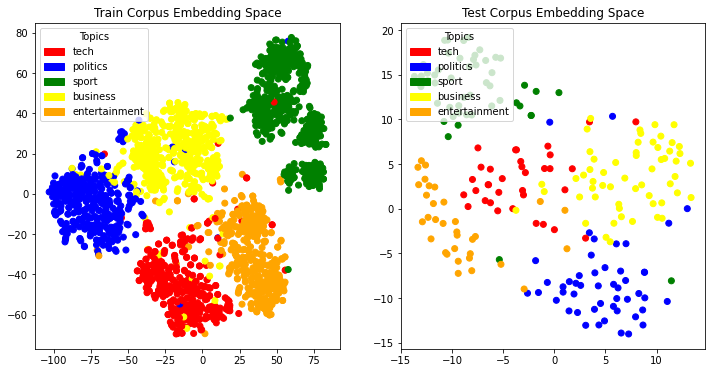

In [31]:
# Obtain the vectorized corpus
vect_train_corpus = np.vstack([doc2vec_model.docvecs[i] for i in range(len(train_corpus))])
vect_test_corpus = np.vstack([doc2vec_model.infer_vector(i) for i in processed_test_corpus])
# vect_mix_corpus = np.vstack([vect_train_corpus, vect_test_corpus])

# Visualize a 2D map of the vectorized corpus
tsne_model = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=5000,
                  n_iter_without_progress=300, metric='cosine', verbose=1)

embedded_train_corpus = tsne_model.fit_transform(vect_train_corpus)
embedded_test_corpus = tsne_model.fit_transform(vect_test_corpus)
# embedded_mix_corpus = np.vstack([embedded_train_corpus, embedded_test_corpus])

categ_map = dict(zip(set(topics), ['red', 'blue', 'green', 'yellow', 'orange']))
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, X, top, tit in zip(axes.flatten(), [embedded_train_corpus, embedded_test_corpus], [train_topics, test_topics],
                           ['Train Corpus Embedding Space', 'Test Corpus Embedding Space']):
    # Color for each point
    color_points = list(map(lambda x: categ_map[x], top))
    # Scatter plot
    ax.scatter(X[:, 0], X[:, 1], c=color_points)
    # Produce a legend with the unique colors from the scatter
    handles = [mpatches.Patch(color=c, label=l) for l, c in categ_map.items()]
    ax.legend(handles=handles, loc="upper left", title="Topics", bbox_to_anchor=(0., 0.6, 0.4, 0.4))
    # Set title
    ax.set_title(tit)
# plt.savefig(os.path.join(models_path, "tsne_news_embeddings.png"))  # exports png to current directory
plt.show()